# 1. Import thư viện

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Tạo Mô hình SR

In [4]:
import torch
import torch.nn as nn
import cv2
import numpy as np

class CannyFilterOpenCV(nn.Module):
    def __init__(self, low_threshold=100, high_threshold=200):
        super(CannyFilterOpenCV, self).__init__()
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

    def forward(self, x):
        x_np = x.cpu().detach().numpy()
        canny_edges_batch = []
        for img in x_np:
            img_np = img.transpose(1, 2, 0)
            img_np = np.uint8(img_np * 255)
            canny_edges = cv2.Canny(img_np, self.low_threshold, self.high_threshold)
            canny_edges = canny_edges / 255.0
            canny_edges_batch.append(canny_edges[np.newaxis, ...])
        canny_edges_tensor = torch.from_numpy(np.array(canny_edges_batch)).float().to(x.device)
        return canny_edges_tensor
    
    def get_output_channels(self):
        return 1  # Canny filter luôn trả về 1 kênh
class SobelFilterOpenCV(nn.Module):
    def __init__(self):
        super(SobelFilterOpenCV, self).__init__()

    def forward(self, x):
        x_np = x.cpu().detach().numpy()
        sobel_edges_batch = []
        for img in x_np:
            img_np = img.transpose(1, 2, 0)
            img_np = np.uint8(img_np * 255)
            sobel_x = cv2.Sobel(img_np, cv2.CV_64F, 1, 0, ksize=3)
            sobel_y = cv2.Sobel(img_np, cv2.CV_64F, 0, 1, ksize=3)
            sobel_edges = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
            sobel_edges = cv2.normalize(sobel_edges, None, 0, 1, cv2.NORM_MINMAX)
            sobel_edges_batch.append(sobel_edges.transpose(2, 0, 1))
        sobel_edges_tensor = torch.from_numpy(np.array(sobel_edges_batch)).float().to(x.device)
        return sobel_edges_tensor

    def get_output_channels(self, input_channels):
        return input_channels  # Sobel filter giữ nguyên số kênh đầu vào
class SR(nn.Module):
    def __init__(self, num_channels=3, scale_factor=4, use_canny=False, use_sobel=False):
        super(SR, self).__init__()
        self.scale_factor = scale_factor
        self.use_canny = use_canny
        self.use_sobel = use_sobel
        
        self.canny_filter = CannyFilterOpenCV() if use_canny else None
        self.sobel_filter = SobelFilterOpenCV() if use_sobel else None
        
        if use_canny:
            additional_channels = 1
        if use_sobel:
            additional_channels = 3
        self.input_conv = nn.Conv2d(num_channels+additional_channels, 64, kernel_size=3, stride=1, padding=1)
        
        self.residual_layers = nn.Sequential(
            *[ResidualCatBlock(64) for _ in range(16)]
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 64*scale_factor**2, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.Conv2d(64, num_channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        edge_maps = []
        if self.use_canny:
            edge_maps.append(self.canny_filter(x))
        if self.use_sobel:
            edge_maps.append(self.sobel_filter(x))
        
        if edge_maps:
            x_with_edges = torch.cat([x] + edge_maps, dim=1)
        else:
            x_with_edges = x
        
        x = self.input_conv(x_with_edges)
        res = self.residual_layers(x)
        out = res + x
        out = self.upsample(out)
        return out

class ResidualCatBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualCatBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        )
        self.conv = nn.Conv2d(num_channels*2, num_channels, kernel_size=1, stride=1)
        
    def forward(self, x):
        out = self.block(x)
        out = torch.cat((x, out), 1)
        out = self.conv(out)
        return x + out

# Usage example:
# scale = 4
# model = SR(scale_factor=scale, use_/=True, use_sobel=True)
# model = nn.DataParallel(model).cuda()
# summary(model, (3, 150, 150))

In [5]:
class ImageDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, scale):
        self.lr_files = sorted(os.listdir(lr_dir))
        self.hr_files = sorted(os.listdir(hr_dir))
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.scale = scale

    def __len__(self):
        return len(self.lr_files)

    def __getitem__(self, idx):
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_files[idx])).convert('RGB')
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_files[idx])).convert('RGB')
    
        size,_= lr_image.shape

        transform_hr = transforms.Compose([
            transforms.Resize(size*self.scale, size*self.scale),
            transforms.ToTensor()
        ])

        transform_lr = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
        lr_image = transform_lr(lr_image)
        hr_image = transform_hr(hr_image)
        return lr_image, hr_image

# 3. Tạo Hyperparameter

In [6]:
# Đường dẫn tới bộ dữ liệu
train_lr_dir = 'dataset/Train/LR'
train_hr_dir = 'dataset/Train/HR'
valid_lr_dir = 'dataset/Test/LR'
valid_hr_dir = 'dataset/Test/HR'
# test_hr_dir  = '/kaggle/input/srdataset/sr_data/test/HR'
# test_lr_dir  = '/kaggle/input/srdataset/sr_data/test/LR'

# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_reserved())

In [7]:
import os
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [7]:
from torch.amp import autocast, GradScaler
from torchsummary import summary
scaler = GradScaler()

# Khởi tạo dataset và dataloader
train_dataset = ImageDataset(train_lr_dir, train_hr_dir)
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle=True)

valid_dataset = ImageDataset(valid_lr_dir, valid_hr_dir)
valid_loader = DataLoader(valid_dataset)
print(len(train_loader))
# Khởi tạo mô hình, loss function và optimizer
torch.cuda.empty_cache()
scale = 4
sobelsr = SR(scale_factor = scale, use_sobel = True).to(device)
# sobelsr = nn.DataParallel(sobelsr).to(device)
sobelsr.load_state_dict(torch.load('weight/best_sobel_srx4_model.pth', map_location=device))
criterion = nn.MSELoss()
optim_sobel = optim.Adam(sobelsr.parameters(), lr=1e-4,betas =(0.9, 0.999))
scheduler_sobel = optim.lr_scheduler.StepLR(optim_sobel, step_size=10**5, gamma=0.5)
# summary(sobelsr.cuda(), input_size=(3, 510, 339), device='cuda')
scale = 4
cannysr = SR(scale_factor = scale, use_canny = True).to(device)
# cannysr = nn.DataParallel(cannysr).to(device)
cannysr.load_state_dict(torch.load('weight/best_canny_srx4_model.pth', map_location=device))
criterion = nn.MSELoss()
optim_canny = optim.Adam(cannysr.parameters(), lr=1e-4,betas =(0.9, 0.999))
scheduler_canny = optim.lr_scheduler.StepLR(optim_canny, step_size=10**5, gamma=0.5)

1067


/tmp/ipykernel_135878/1142799224.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sobelsr.load_state_dict(torch.load('weight/best_sobel_srx4_model.pth', map_location=dev

In [8]:
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr.item()

# 4. Training

Validation Epoch 1/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.87batch/s]


Epoch 1/100, Loss sobel: 0.0009, Loss canny: 0.0009, Time training: 87.8022s, PSNR sobel: 30.53 dB, PSNR canny: 30.55 dB, Val PSNR sobel: 31.93 dB, Val PSNR canny: 31.89 dB
Saved Sobel SR model with PSNR 31.9313
Saved Canny SR model with PSNR 31.8890


Validation Epoch 2/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.65batch/s]


Epoch 2/100, Loss sobel: 0.0006, Loss canny: 0.0006, Time training: 87.2776s, PSNR sobel: 32.44 dB, PSNR canny: 32.43 dB, Val PSNR sobel: 32.74 dB, Val PSNR canny: 32.79 dB
Saved Sobel SR model with PSNR 32.7444
Saved Canny SR model with PSNR 32.7912


Validation Epoch 3/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.67batch/s]


Epoch 3/100, Loss sobel: 0.0005, Loss canny: 0.0005, Time training: 87.4491s, PSNR sobel: 33.23 dB, PSNR canny: 33.22 dB, Val PSNR sobel: 33.24 dB, Val PSNR canny: 33.16 dB
Saved Sobel SR model with PSNR 33.2398
Saved Canny SR model with PSNR 33.1625


Validation Epoch 4/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.89batch/s]


Epoch 4/100, Loss sobel: 0.0004, Loss canny: 0.0004, Time training: 87.6513s, PSNR sobel: 33.76 dB, PSNR canny: 33.76 dB, Val PSNR sobel: 33.47 dB, Val PSNR canny: 33.49 dB
Saved Sobel SR model with PSNR 33.4706
Saved Canny SR model with PSNR 33.4936


Validation Epoch 5/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.98batch/s]


Epoch 5/100, Loss sobel: 0.0004, Loss canny: 0.0004, Time training: 87.9562s, PSNR sobel: 34.14 dB, PSNR canny: 34.15 dB, Val PSNR sobel: 33.68 dB, Val PSNR canny: 33.67 dB
Saved Sobel SR model with PSNR 33.6829
Saved Canny SR model with PSNR 33.6749


Validation Epoch 6/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.91batch/s]


Epoch 6/100, Loss sobel: 0.0004, Loss canny: 0.0004, Time training: 87.7627s, PSNR sobel: 34.44 dB, PSNR canny: 34.47 dB, Val PSNR sobel: 33.88 dB, Val PSNR canny: 33.90 dB
Saved Sobel SR model with PSNR 33.8818
Saved Canny SR model with PSNR 33.8979


Validation Epoch 7/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.69batch/s]


Epoch 7/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.9645s, PSNR sobel: 34.73 dB, PSNR canny: 34.73 dB, Val PSNR sobel: 33.93 dB, Val PSNR canny: 33.97 dB
Saved Sobel SR model with PSNR 33.9323
Saved Canny SR model with PSNR 33.9729


Validation Epoch 8/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.79batch/s]


Epoch 8/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.3937s, PSNR sobel: 34.93 dB, PSNR canny: 34.94 dB, Val PSNR sobel: 34.10 dB, Val PSNR canny: 34.15 dB
Saved Sobel SR model with PSNR 34.1046
Saved Canny SR model with PSNR 34.1543


Validation Epoch 9/100: 100%|██████████| 1068/1068 [00:11<00:00, 91.13batch/s]


Epoch 9/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 88.4269s, PSNR sobel: 35.11 dB, PSNR canny: 35.14 dB, Val PSNR sobel: 34.20 dB, Val PSNR canny: 34.21 dB
Saved Sobel SR model with PSNR 34.1991
Saved Canny SR model with PSNR 34.2147


Validation Epoch 10/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.53batch/s]


Epoch 10/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.6040s, PSNR sobel: 35.28 dB, PSNR canny: 35.29 dB, Val PSNR sobel: 34.24 dB, Val PSNR canny: 34.24 dB
Saved Sobel SR model with PSNR 34.2350
Saved Canny SR model with PSNR 34.2363


Validation Epoch 11/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.06batch/s]


Epoch 11/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.6414s, PSNR sobel: 35.41 dB, PSNR canny: 35.45 dB, Val PSNR sobel: 34.27 dB, Val PSNR canny: 34.33 dB
Saved Sobel SR model with PSNR 34.2693
Saved Canny SR model with PSNR 34.3328


Validation Epoch 12/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.08batch/s]


Epoch 12/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.5920s, PSNR sobel: 35.55 dB, PSNR canny: 35.59 dB, Val PSNR sobel: 34.40 dB, Val PSNR canny: 34.39 dB
Saved Sobel SR model with PSNR 34.4037
Saved Canny SR model with PSNR 34.3902


Validation Epoch 13/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.06batch/s]


Epoch 13/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.7677s, PSNR sobel: 35.67 dB, PSNR canny: 35.70 dB, Val PSNR sobel: 34.43 dB, Val PSNR canny: 34.46 dB
Saved Sobel SR model with PSNR 34.4286
Saved Canny SR model with PSNR 34.4616


Validation Epoch 14/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.83batch/s]


Epoch 14/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.2692s, PSNR sobel: 35.78 dB, PSNR canny: 35.81 dB, Val PSNR sobel: 34.45 dB, Val PSNR canny: 34.49 dB
Saved Sobel SR model with PSNR 34.4541
Saved Canny SR model with PSNR 34.4894


Validation Epoch 15/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.07batch/s]


Epoch 15/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.3315s, PSNR sobel: 35.88 dB, PSNR canny: 35.92 dB, Val PSNR sobel: 34.52 dB, Val PSNR canny: 34.54 dB
Saved Sobel SR model with PSNR 34.5209
Saved Canny SR model with PSNR 34.5444


Validation Epoch 16/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.57batch/s]


Epoch 16/100, Loss sobel: 0.0003, Loss canny: 0.0003, Time training: 87.4979s, PSNR sobel: 35.98 dB, PSNR canny: 36.01 dB, Val PSNR sobel: 34.52 dB, Val PSNR canny: 34.57 dB
Saved Canny SR model with PSNR 34.5684


Validation Epoch 17/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.00batch/s]


Epoch 17/100, Loss sobel: 0.0003, Loss canny: 0.0002, Time training: 88.2994s, PSNR sobel: 36.05 dB, PSNR canny: 36.09 dB, Val PSNR sobel: 34.55 dB, Val PSNR canny: 34.56 dB
Saved Sobel SR model with PSNR 34.5532


Validation Epoch 18/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.40batch/s]


Epoch 18/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2824s, PSNR sobel: 36.14 dB, PSNR canny: 36.18 dB, Val PSNR sobel: 34.57 dB, Val PSNR canny: 34.62 dB
Saved Sobel SR model with PSNR 34.5657
Saved Canny SR model with PSNR 34.6169


Validation Epoch 19/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.06batch/s]


Epoch 19/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.1267s, PSNR sobel: 36.21 dB, PSNR canny: 36.25 dB, Val PSNR sobel: 34.56 dB, Val PSNR canny: 34.66 dB
Saved Canny SR model with PSNR 34.6616


Validation Epoch 20/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.16batch/s]


Epoch 20/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3372s, PSNR sobel: 36.28 dB, PSNR canny: 36.32 dB, Val PSNR sobel: 34.62 dB, Val PSNR canny: 34.58 dB
Saved Sobel SR model with PSNR 34.6162


Validation Epoch 21/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.37batch/s]


Epoch 21/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6292s, PSNR sobel: 36.35 dB, PSNR canny: 36.40 dB, Val PSNR sobel: 34.66 dB, Val PSNR canny: 34.71 dB
Saved Sobel SR model with PSNR 34.6593
Saved Canny SR model with PSNR 34.7093


Validation Epoch 22/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.36batch/s]


Epoch 22/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6378s, PSNR sobel: 36.42 dB, PSNR canny: 36.46 dB, Val PSNR sobel: 34.68 dB, Val PSNR canny: 34.68 dB
Saved Sobel SR model with PSNR 34.6793


Validation Epoch 23/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.24batch/s]


Epoch 23/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6581s, PSNR sobel: 36.48 dB, PSNR canny: 36.51 dB, Val PSNR sobel: 34.70 dB, Val PSNR canny: 34.73 dB
Saved Sobel SR model with PSNR 34.7043
Saved Canny SR model with PSNR 34.7273


Validation Epoch 24/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.12batch/s]


Epoch 24/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6146s, PSNR sobel: 36.52 dB, PSNR canny: 36.59 dB, Val PSNR sobel: 34.68 dB, Val PSNR canny: 34.63 dB


Validation Epoch 25/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.00batch/s]


Epoch 25/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.5932s, PSNR sobel: 36.60 dB, PSNR canny: 36.63 dB, Val PSNR sobel: 34.72 dB, Val PSNR canny: 34.75 dB
Saved Sobel SR model with PSNR 34.7154
Saved Canny SR model with PSNR 34.7500


Validation Epoch 26/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.80batch/s]


Epoch 26/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3422s, PSNR sobel: 36.64 dB, PSNR canny: 36.69 dB, Val PSNR sobel: 34.75 dB, Val PSNR canny: 34.77 dB
Saved Sobel SR model with PSNR 34.7479
Saved Canny SR model with PSNR 34.7690


Validation Epoch 27/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.13batch/s]


Epoch 27/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.5006s, PSNR sobel: 36.70 dB, PSNR canny: 36.74 dB, Val PSNR sobel: 34.75 dB, Val PSNR canny: 34.78 dB
Saved Sobel SR model with PSNR 34.7487
Saved Canny SR model with PSNR 34.7800


Validation Epoch 28/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.10batch/s]


Epoch 28/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6133s, PSNR sobel: 36.73 dB, PSNR canny: 36.79 dB, Val PSNR sobel: 34.77 dB, Val PSNR canny: 34.83 dB
Saved Sobel SR model with PSNR 34.7700
Saved Canny SR model with PSNR 34.8285


Validation Epoch 29/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.84batch/s]


Epoch 29/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6796s, PSNR sobel: 36.80 dB, PSNR canny: 36.84 dB, Val PSNR sobel: 34.81 dB, Val PSNR canny: 34.82 dB
Saved Sobel SR model with PSNR 34.8061


Validation Epoch 30/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.32batch/s]


Epoch 30/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.9932s, PSNR sobel: 36.82 dB, PSNR canny: 36.87 dB, Val PSNR sobel: 34.79 dB, Val PSNR canny: 34.82 dB


Validation Epoch 31/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.23batch/s]


Epoch 31/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4109s, PSNR sobel: 36.87 dB, PSNR canny: 36.93 dB, Val PSNR sobel: 34.83 dB, Val PSNR canny: 34.85 dB
Saved Sobel SR model with PSNR 34.8308
Saved Canny SR model with PSNR 34.8459


Validation Epoch 32/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.74batch/s]


Epoch 32/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4473s, PSNR sobel: 36.91 dB, PSNR canny: 36.97 dB, Val PSNR sobel: 34.78 dB, Val PSNR canny: 34.83 dB


Validation Epoch 33/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.74batch/s]


Epoch 33/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.1145s, PSNR sobel: 36.95 dB, PSNR canny: 37.01 dB, Val PSNR sobel: 34.80 dB, Val PSNR canny: 34.86 dB
Saved Canny SR model with PSNR 34.8618


Validation Epoch 34/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.11batch/s]


Epoch 34/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3875s, PSNR sobel: 36.99 dB, PSNR canny: 37.04 dB, Val PSNR sobel: 34.85 dB, Val PSNR canny: 34.87 dB
Saved Sobel SR model with PSNR 34.8520
Saved Canny SR model with PSNR 34.8720


Validation Epoch 35/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.11batch/s]


Epoch 35/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2957s, PSNR sobel: 37.03 dB, PSNR canny: 37.09 dB, Val PSNR sobel: 34.85 dB, Val PSNR canny: 34.90 dB
Saved Sobel SR model with PSNR 34.8533
Saved Canny SR model with PSNR 34.9007


Validation Epoch 36/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.21batch/s]


Epoch 36/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.5515s, PSNR sobel: 37.06 dB, PSNR canny: 37.12 dB, Val PSNR sobel: 34.84 dB, Val PSNR canny: 34.89 dB


Validation Epoch 37/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.88batch/s]


Epoch 37/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2787s, PSNR sobel: 37.10 dB, PSNR canny: 37.16 dB, Val PSNR sobel: 34.89 dB, Val PSNR canny: 34.89 dB
Saved Sobel SR model with PSNR 34.8895


Validation Epoch 38/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.90batch/s]


Epoch 38/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.9482s, PSNR sobel: 37.13 dB, PSNR canny: 37.19 dB, Val PSNR sobel: 34.86 dB, Val PSNR canny: 34.91 dB
Saved Canny SR model with PSNR 34.9062


Validation Epoch 39/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.83batch/s]


Epoch 39/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7460s, PSNR sobel: 37.16 dB, PSNR canny: 37.22 dB, Val PSNR sobel: 34.85 dB, Val PSNR canny: 34.88 dB


Validation Epoch 40/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.50batch/s]


Epoch 40/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.2166s, PSNR sobel: 37.18 dB, PSNR canny: 37.26 dB, Val PSNR sobel: 34.84 dB, Val PSNR canny: 34.92 dB
Saved Canny SR model with PSNR 34.9187


Validation Epoch 41/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.77batch/s]


Epoch 41/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.0753s, PSNR sobel: 37.22 dB, PSNR canny: 37.29 dB, Val PSNR sobel: 34.88 dB, Val PSNR canny: 34.94 dB
Saved Canny SR model with PSNR 34.9372


Validation Epoch 42/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.32batch/s]


Epoch 42/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7707s, PSNR sobel: 37.25 dB, PSNR canny: 37.31 dB, Val PSNR sobel: 34.91 dB, Val PSNR canny: 34.94 dB
Saved Sobel SR model with PSNR 34.9128
Saved Canny SR model with PSNR 34.9392


Validation Epoch 43/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.68batch/s]


Epoch 43/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.5590s, PSNR sobel: 37.28 dB, PSNR canny: 37.35 dB, Val PSNR sobel: 34.90 dB, Val PSNR canny: 34.92 dB


Validation Epoch 44/100: 100%|██████████| 1068/1068 [00:11<00:00, 91.33batch/s]


Epoch 44/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.2112s, PSNR sobel: 37.32 dB, PSNR canny: 37.38 dB, Val PSNR sobel: 34.90 dB, Val PSNR canny: 34.93 dB


Validation Epoch 45/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.76batch/s]


Epoch 45/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.9502s, PSNR sobel: 37.32 dB, PSNR canny: 37.39 dB, Val PSNR sobel: 34.92 dB, Val PSNR canny: 34.96 dB
Saved Sobel SR model with PSNR 34.9192
Saved Canny SR model with PSNR 34.9618


Validation Epoch 46/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.23batch/s]


Epoch 46/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2154s, PSNR sobel: 37.35 dB, PSNR canny: 37.42 dB, Val PSNR sobel: 34.91 dB, Val PSNR canny: 34.99 dB
Saved Canny SR model with PSNR 34.9893


Validation Epoch 47/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.03batch/s]


Epoch 47/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8457s, PSNR sobel: 37.39 dB, PSNR canny: 37.45 dB, Val PSNR sobel: 34.92 dB, Val PSNR canny: 34.98 dB


Validation Epoch 48/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.29batch/s]


Epoch 48/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6469s, PSNR sobel: 37.41 dB, PSNR canny: 37.49 dB, Val PSNR sobel: 34.93 dB, Val PSNR canny: 34.98 dB
Saved Sobel SR model with PSNR 34.9277


Validation Epoch 49/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.32batch/s]


Epoch 49/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4184s, PSNR sobel: 37.42 dB, PSNR canny: 37.50 dB, Val PSNR sobel: 34.95 dB, Val PSNR canny: 35.00 dB
Saved Sobel SR model with PSNR 34.9532
Saved Canny SR model with PSNR 35.0037


Validation Epoch 50/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.58batch/s]


Epoch 50/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4412s, PSNR sobel: 37.46 dB, PSNR canny: 37.52 dB, Val PSNR sobel: 34.93 dB, Val PSNR canny: 34.97 dB


Validation Epoch 51/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.98batch/s]


Epoch 51/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4629s, PSNR sobel: 37.48 dB, PSNR canny: 37.57 dB, Val PSNR sobel: 34.94 dB, Val PSNR canny: 34.99 dB


Validation Epoch 52/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.80batch/s]


Epoch 52/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6710s, PSNR sobel: 37.52 dB, PSNR canny: 37.59 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 34.98 dB
Saved Sobel SR model with PSNR 34.9565


Validation Epoch 53/100: 100%|██████████| 1068/1068 [00:11<00:00, 95.43batch/s]


Epoch 53/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3679s, PSNR sobel: 37.52 dB, PSNR canny: 37.60 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 35.00 dB


Validation Epoch 54/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.09batch/s]


Epoch 54/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4473s, PSNR sobel: 37.55 dB, PSNR canny: 37.62 dB, Val PSNR sobel: 34.95 dB, Val PSNR canny: 34.99 dB


Validation Epoch 55/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.03batch/s]


Epoch 55/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4121s, PSNR sobel: 37.56 dB, PSNR canny: 37.64 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 35.00 dB
Saved Sobel SR model with PSNR 34.9585


Validation Epoch 56/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.63batch/s]


Epoch 56/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2609s, PSNR sobel: 37.59 dB, PSNR canny: 37.67 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 34.99 dB
Saved Sobel SR model with PSNR 34.9643


Validation Epoch 57/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.17batch/s]


Epoch 57/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2449s, PSNR sobel: 37.61 dB, PSNR canny: 37.69 dB, Val PSNR sobel: 34.94 dB, Val PSNR canny: 34.96 dB


Validation Epoch 58/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.12batch/s]


Epoch 58/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.0297s, PSNR sobel: 37.61 dB, PSNR canny: 37.69 dB, Val PSNR sobel: 34.98 dB, Val PSNR canny: 35.03 dB
Saved Sobel SR model with PSNR 34.9809
Saved Canny SR model with PSNR 35.0289


Validation Epoch 59/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.63batch/s]


Epoch 59/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4409s, PSNR sobel: 37.67 dB, PSNR canny: 37.73 dB, Val PSNR sobel: 34.89 dB, Val PSNR canny: 34.95 dB


Validation Epoch 60/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.88batch/s]


Epoch 60/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8363s, PSNR sobel: 37.66 dB, PSNR canny: 37.75 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 34.98 dB


Validation Epoch 61/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.00batch/s]


Epoch 61/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6294s, PSNR sobel: 37.68 dB, PSNR canny: 37.76 dB, Val PSNR sobel: 34.95 dB, Val PSNR canny: 35.00 dB


Validation Epoch 62/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.85batch/s]


Epoch 62/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.9269s, PSNR sobel: 37.70 dB, PSNR canny: 37.77 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 35.01 dB


Validation Epoch 63/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.24batch/s]


Epoch 63/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8292s, PSNR sobel: 37.73 dB, PSNR canny: 37.81 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 35.02 dB


Validation Epoch 64/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.70batch/s]


Epoch 64/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7456s, PSNR sobel: 37.72 dB, PSNR canny: 37.81 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 35.02 dB


Validation Epoch 65/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.49batch/s]


Epoch 65/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.9686s, PSNR sobel: 37.77 dB, PSNR canny: 37.83 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.04 dB
Saved Sobel SR model with PSNR 34.9891
Saved Canny SR model with PSNR 35.0354


Validation Epoch 66/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.32batch/s]


Epoch 66/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8238s, PSNR sobel: 37.76 dB, PSNR canny: 37.84 dB, Val PSNR sobel: 35.00 dB, Val PSNR canny: 35.06 dB
Saved Sobel SR model with PSNR 34.9986
Saved Canny SR model with PSNR 35.0556


Validation Epoch 67/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.37batch/s]


Epoch 67/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4011s, PSNR sobel: 37.81 dB, PSNR canny: 37.87 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 35.04 dB


Validation Epoch 68/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.89batch/s]


Epoch 68/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3726s, PSNR sobel: 37.80 dB, PSNR canny: 37.90 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 35.00 dB


Validation Epoch 69/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.45batch/s]


Epoch 69/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.1233s, PSNR sobel: 37.82 dB, PSNR canny: 37.90 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.04 dB


Validation Epoch 70/100: 100%|██████████| 1068/1068 [00:11<00:00, 90.58batch/s]


Epoch 70/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8745s, PSNR sobel: 37.82 dB, PSNR canny: 37.91 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.04 dB


Validation Epoch 71/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.17batch/s]


Epoch 71/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6144s, PSNR sobel: 37.85 dB, PSNR canny: 37.93 dB, Val PSNR sobel: 34.98 dB, Val PSNR canny: 35.03 dB


Validation Epoch 72/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.74batch/s]


Epoch 72/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6965s, PSNR sobel: 37.86 dB, PSNR canny: 37.94 dB, Val PSNR sobel: 35.01 dB, Val PSNR canny: 35.08 dB
Saved Sobel SR model with PSNR 35.0137
Saved Canny SR model with PSNR 35.0752


Validation Epoch 73/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.75batch/s]


Epoch 73/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3778s, PSNR sobel: 37.88 dB, PSNR canny: 37.97 dB, Val PSNR sobel: 35.03 dB, Val PSNR canny: 35.05 dB
Saved Sobel SR model with PSNR 35.0279


Validation Epoch 74/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.42batch/s]


Epoch 74/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4039s, PSNR sobel: 37.89 dB, PSNR canny: 37.99 dB, Val PSNR sobel: 34.98 dB, Val PSNR canny: 35.00 dB


Validation Epoch 75/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.68batch/s]


Epoch 75/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6432s, PSNR sobel: 37.90 dB, PSNR canny: 37.97 dB, Val PSNR sobel: 35.02 dB, Val PSNR canny: 35.02 dB


Validation Epoch 76/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.97batch/s]


Epoch 76/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.3077s, PSNR sobel: 37.93 dB, PSNR canny: 38.03 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.05 dB


Validation Epoch 77/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.30batch/s]


Epoch 77/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8273s, PSNR sobel: 37.94 dB, PSNR canny: 38.02 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.01 dB


Validation Epoch 78/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.57batch/s]


Epoch 78/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4454s, PSNR sobel: 37.96 dB, PSNR canny: 38.03 dB, Val PSNR sobel: 35.03 dB, Val PSNR canny: 35.06 dB
Saved Sobel SR model with PSNR 35.0334


Validation Epoch 79/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.16batch/s]


Epoch 79/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6037s, PSNR sobel: 37.96 dB, PSNR canny: 38.05 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.04 dB


Validation Epoch 80/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.71batch/s]


Epoch 80/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6676s, PSNR sobel: 37.97 dB, PSNR canny: 38.06 dB, Val PSNR sobel: 35.00 dB, Val PSNR canny: 35.07 dB


Validation Epoch 81/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.58batch/s]


Epoch 81/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4969s, PSNR sobel: 37.98 dB, PSNR canny: 38.07 dB, Val PSNR sobel: 35.02 dB, Val PSNR canny: 35.02 dB


Validation Epoch 82/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.86batch/s]


Epoch 82/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4132s, PSNR sobel: 37.99 dB, PSNR canny: 38.06 dB, Val PSNR sobel: 35.02 dB, Val PSNR canny: 35.06 dB


Validation Epoch 83/100: 100%|██████████| 1068/1068 [00:11<00:00, 90.91batch/s]


Epoch 83/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8737s, PSNR sobel: 38.02 dB, PSNR canny: 38.11 dB, Val PSNR sobel: 35.00 dB, Val PSNR canny: 35.06 dB


Validation Epoch 84/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.77batch/s]


Epoch 84/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6426s, PSNR sobel: 38.03 dB, PSNR canny: 38.12 dB, Val PSNR sobel: 35.00 dB, Val PSNR canny: 35.02 dB


Validation Epoch 85/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.46batch/s]


Epoch 85/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.6048s, PSNR sobel: 38.02 dB, PSNR canny: 38.12 dB, Val PSNR sobel: 35.02 dB, Val PSNR canny: 35.08 dB


Validation Epoch 86/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.67batch/s]


Epoch 86/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 88.2141s, PSNR sobel: 38.04 dB, PSNR canny: 38.11 dB, Val PSNR sobel: 35.03 dB, Val PSNR canny: 35.06 dB


Validation Epoch 87/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.47batch/s]


Epoch 87/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8156s, PSNR sobel: 38.07 dB, PSNR canny: 38.16 dB, Val PSNR sobel: 35.00 dB, Val PSNR canny: 35.04 dB


Validation Epoch 88/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.45batch/s]


Epoch 88/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7268s, PSNR sobel: 38.09 dB, PSNR canny: 38.17 dB, Val PSNR sobel: 34.98 dB, Val PSNR canny: 35.04 dB


Validation Epoch 89/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.23batch/s]


Epoch 89/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.8132s, PSNR sobel: 38.08 dB, PSNR canny: 38.19 dB, Val PSNR sobel: 35.01 dB, Val PSNR canny: 35.01 dB


Validation Epoch 90/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.11batch/s]


Epoch 90/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7750s, PSNR sobel: 38.10 dB, PSNR canny: 38.18 dB, Val PSNR sobel: 35.04 dB, Val PSNR canny: 35.08 dB
Saved Sobel SR model with PSNR 35.0436
Saved Canny SR model with PSNR 35.0794


Validation Epoch 91/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.78batch/s]


Epoch 91/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.4872s, PSNR sobel: 38.11 dB, PSNR canny: 38.19 dB, Val PSNR sobel: 35.01 dB, Val PSNR canny: 35.05 dB


Validation Epoch 92/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.95batch/s]


Epoch 92/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.2495s, PSNR sobel: 38.10 dB, PSNR canny: 38.22 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 34.98 dB


Validation Epoch 93/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.65batch/s]


Epoch 93/100, Loss sobel: 0.0002, Loss canny: 0.0002, Time training: 87.7319s, PSNR sobel: 38.14 dB, PSNR canny: 38.21 dB, Val PSNR sobel: 34.98 dB, Val PSNR canny: 35.04 dB


Validation Epoch 94/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.16batch/s]


Epoch 94/100, Loss sobel: 0.0002, Loss canny: 0.0001, Time training: 87.8474s, PSNR sobel: 38.23 dB, PSNR canny: 38.31 dB, Val PSNR sobel: 35.07 dB, Val PSNR canny: 35.11 dB
Saved Sobel SR model with PSNR 35.0705
Saved Canny SR model with PSNR 35.1079


Validation Epoch 95/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.52batch/s]


Epoch 95/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 87.6242s, PSNR sobel: 38.49 dB, PSNR canny: 38.57 dB, Val PSNR sobel: 35.01 dB, Val PSNR canny: 35.06 dB


Validation Epoch 96/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.20batch/s]


Epoch 96/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 87.1888s, PSNR sobel: 38.47 dB, PSNR canny: 38.55 dB, Val PSNR sobel: 34.99 dB, Val PSNR canny: 35.03 dB


Validation Epoch 97/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.91batch/s]


Epoch 97/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 87.3400s, PSNR sobel: 38.46 dB, PSNR canny: 38.55 dB, Val PSNR sobel: 34.97 dB, Val PSNR canny: 35.02 dB


Validation Epoch 98/100: 100%|██████████| 1068/1068 [00:11<00:00, 94.00batch/s]


Epoch 98/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 87.6576s, PSNR sobel: 38.48 dB, PSNR canny: 38.56 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 35.02 dB


Validation Epoch 99/100: 100%|██████████| 1068/1068 [00:11<00:00, 93.30batch/s]


Epoch 99/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 88.0187s, PSNR sobel: 38.48 dB, PSNR canny: 38.57 dB, Val PSNR sobel: 34.94 dB, Val PSNR canny: 34.99 dB


Validation Epoch 100/100: 100%|██████████| 1068/1068 [00:11<00:00, 92.74batch/s]


Epoch 100/100, Loss sobel: 0.0001, Loss canny: 0.0001, Time training: 88.1447s, PSNR sobel: 38.49 dB, PSNR canny: 38.58 dB, Val PSNR sobel: 34.96 dB, Val PSNR canny: 35.00 dB


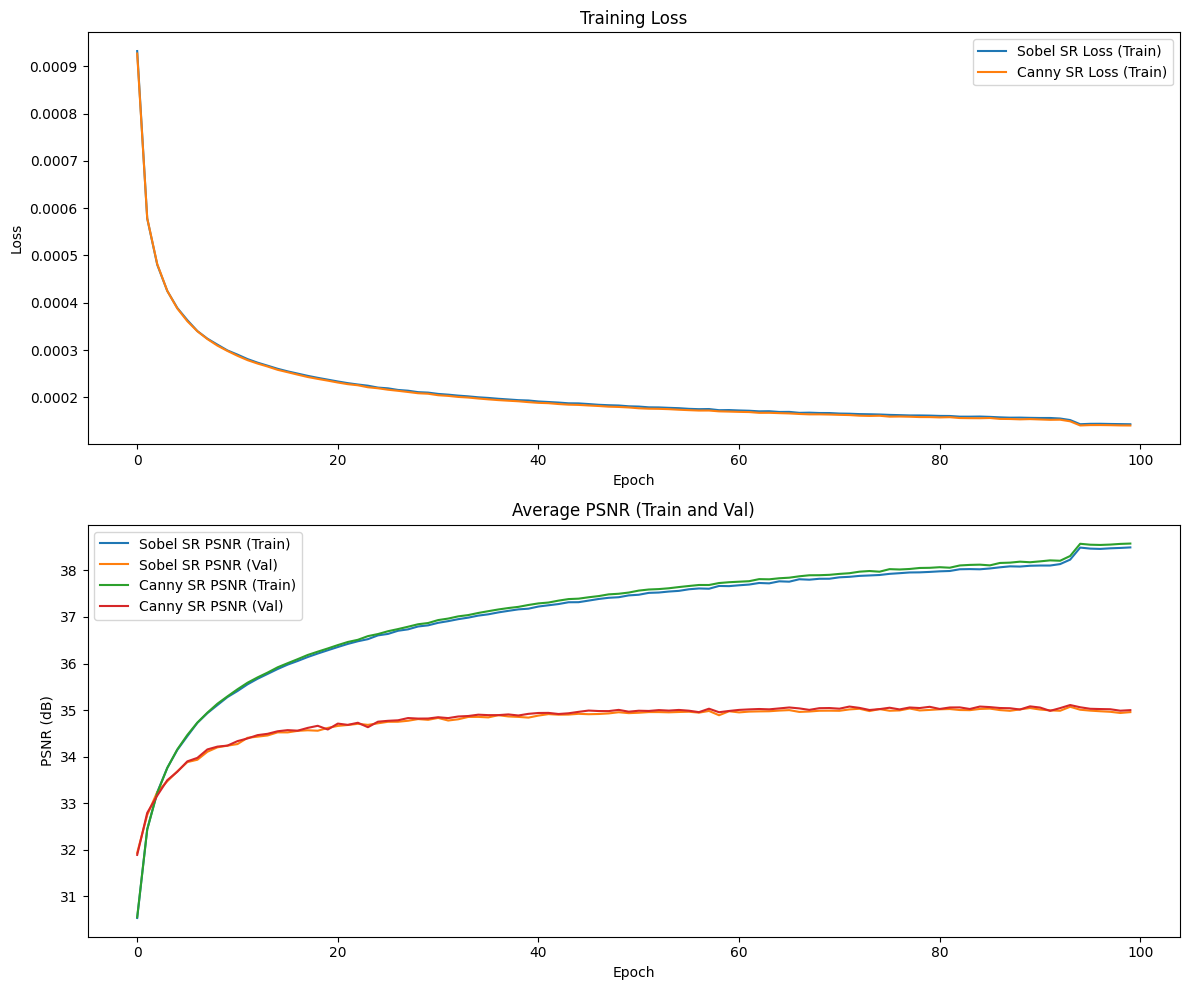

In [9]:
num_epochs = 100

best_psnr_sobel = float('-inf')
best_psnr_canny = float('-inf')
torch.cuda.empty_cache()

losses_sobel = []
losses_canny = []
avg_psnr_sobel = []
avg_psnr_canny = []

val_avg_psnr_sobel = []  # Validation PSNR
val_avg_psnr_canny = []

patience = 50
epochs_no_improve = 0
log_file = open('training_log.txt', 'a')
scaler = GradScaler()

for epoch in range(num_epochs):
    sobelsr.train()
    cannysr.train()

    epoch_loss_sobel = 0
    psnr_values_sobel = 0
    epoch_loss_canny = 0
    psnr_values_canny = 0
    start_time = time.time()

    # Training loop
    for (lr_images, hr_images) in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        lr_images = lr_images.cuda()
        hr_images = hr_images.cuda()

        # Sobel SR training
        optim_sobel.zero_grad()  
        with autocast(device_type='cuda'):
            outputs_sobel = sobelsr(lr_images)
            loss_sobel = criterion(outputs_sobel, hr_images)
        psnr_sobel = calculate_psnr(outputs_sobel, hr_images)
            
        scaler.scale(loss_sobel).backward()
        scaler.step(optim_sobel)
        scaler.update()
        scheduler_sobel.step()

        # Canny SR training
        optim_canny.zero_grad()  
        with autocast(device_type='cuda'):
            outputs_canny = cannysr(lr_images)
            loss_canny = criterion(outputs_canny, hr_images)
        psnr_canny = calculate_psnr(outputs_canny, hr_images)

        scaler.scale(loss_canny).backward()
        scaler.step(optim_canny)
        scaler.update()
        scheduler_canny.step()
        
        # Update metrics
        epoch_loss_sobel += loss_sobel.item()
        psnr_values_sobel += psnr_sobel
        epoch_loss_canny += loss_canny.item()
        psnr_values_canny += psnr_canny

    # Calculate average training metrics
    avg_epoch_loss_sobel = epoch_loss_sobel / len(train_loader)
    average_psnr_sobel = psnr_values_sobel / len(train_loader)
    losses_sobel.append(avg_epoch_loss_sobel)
    avg_psnr_sobel.append(average_psnr_sobel)

    avg_epoch_loss_canny = epoch_loss_canny / len(train_loader)
    average_psnr_canny = psnr_values_canny / len(train_loader)
    losses_canny.append(avg_epoch_loss_canny)
    avg_psnr_canny.append(average_psnr_canny)

    # Validation step
    sobelsr.eval()
    cannysr.eval()

    val_psnr_values_sobel = 0
    val_psnr_values_canny = 0

    with torch.no_grad():  # No gradients during validation
        for (lr_images, hr_images) in tqdm(valid_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
            lr_images = lr_images.cuda()
            hr_images = hr_images.cuda()

            # Sobel SR validation (no loss, only PSNR)
            outputs_sobel = sobelsr(lr_images)
            psnr_sobel = calculate_psnr(outputs_sobel, hr_images)

            # Canny SR validation (no loss, only PSNR)
            outputs_canny = cannysr(lr_images)
            psnr_canny = calculate_psnr(outputs_canny, hr_images)

            # Update validation PSNR
            val_psnr_values_sobel += psnr_sobel
            val_psnr_values_canny += psnr_canny

    # Calculate average validation PSNR
    val_average_psnr_sobel = val_psnr_values_sobel / len(valid_loader)
    val_avg_psnr_sobel.append(val_average_psnr_sobel)

    val_average_psnr_canny = val_psnr_values_canny / len(valid_loader)
    val_avg_psnr_canny.append(val_average_psnr_canny)

    end_time = time.time()

    # Logging results
    log_string = (f"Epoch {epoch+1}/{num_epochs}, Loss sobel: {avg_epoch_loss_sobel:.4f}, "
                  f"Loss canny: {avg_epoch_loss_canny:.4f}, Time training: {end_time - start_time:.4f}s, "
                  f"PSNR sobel: {average_psnr_sobel:.2f} dB, PSNR canny: {average_psnr_canny:.2f} dB, "
                  f"Val PSNR sobel: {val_average_psnr_sobel:.2f} dB, Val PSNR canny: {val_average_psnr_canny:.2f} dB")
    print(log_string)
    log_file.write(log_string + '\n')
    log_file.flush()

    # Save best models based on validation PSNR
    if val_average_psnr_sobel > best_psnr_sobel:
        best_psnr_sobel = val_average_psnr_sobel
        torch.save(sobelsr.state_dict(), f'best_sobel_srx{scale}_model.pth')
        print(f"Saved Sobel SR model with PSNR {best_psnr_sobel:.4f}")
        epochs_no_improve=0
    

    if val_average_psnr_canny > best_psnr_canny:
        best_psnr_canny = val_average_psnr_canny
        torch.save(cannysr.state_dict(), f'best_canny_srx{scale}_model.pth')
        print(f"Saved Canny SR model with PSNR {best_psnr_canny:.4f}")
        epochs_no_improve=0
    
    if (val_average_psnr_sobel < best_psnr_sobel) and (val_average_psnr_canny < best_psnr_canny):
        epochs_no_improve+=1
    if epochs_no_improve >= patience:
        print(f"PSNR did not improve for 50 epochs. Early stopping at epoch {epoch+1}")
        break
    # Clear cache and optionally save models at each epoch
    torch.cuda.empty_cache()
    torch.save(sobelsr.state_dict(), 'sobel_sr.pth')
    torch.save(cannysr.state_dict(), 'canny_sr.pth')

# Close log file after training
log_file.close()

# Plotting results
plt.figure(figsize=(12, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(losses_sobel, label='Sobel SR Loss (Train)')
plt.plot(losses_canny, label='Canny SR Loss (Train)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Plot PSNR
plt.subplot(2, 1, 2)
plt.plot(avg_psnr_sobel, label='Sobel SR PSNR (Train)')
plt.plot(val_avg_psnr_sobel, label='Sobel SR PSNR (Val)')
plt.plot(avg_psnr_canny, label='Canny SR PSNR (Train)')
plt.plot(val_avg_psnr_canny, label='Canny SR PSNR (Val)')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.title('Average PSNR (Train and Val)')

plt.tight_layout()
plt.show()

# 5. Testing

In [10]:
cannysr = cannysr.cpu()
sobelsr = sobelsr.cpu()
sobelsr.eval()
cannysr.eval()

val_psnr_values_sobel = 0
val_psnr_values_canny = 0
torch.cuda.empty_cache()
with torch.no_grad():  # No gradients during validation
        for (lr_images, hr_images) in tqdm(valid_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
                lr_images = lr_images.cpu()
                hr_images = hr_images.cpu()

                # Sobel SR validation (no loss, only PSNR)
                outputs_sobel = sobelsr(lr_images)
                psnr_sobel = calculate_psnr(outputs_sobel, hr_images)

                # Canny SR validation (no loss, only PSNR)
                outputs_canny = cannysr(lr_images)
                psnr_canny = calculate_psnr(outputs_canny, hr_images)

                # Update validation PSNR
                val_psnr_values_sobel += psnr_sobel
                val_psnr_values_canny += psnr_canny

        # Calculate average validation PSNR
        val_average_psnr_sobel = val_psnr_values_sobel / len(valid_loader)

        val_average_psnr_canny = val_psnr_values_canny / len(valid_loader)
        print(val_average_psnr_canny, val_average_psnr_sobel)

Validation Epoch 100/100: 100%|██████████| 1068/1068 [00:29<00:00, 36.72batch/s]

34.99811347325643 34.955485554670126


In [ ]:
cannysr = cannysr.cpu()
sobelsr = sobelsr.cpu()
sobelsr.eval()
cannysr.eval()

val_psnr_values_sobel = 0
val_psnr_values_canny = 0
torch.cuda.empty_cache()
with torch.no_grad():  # No gradients during validation
        for (lr_images, hr_images) in tqdm(valid_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}', unit='batch'):
                lr_images = lr_images.cpu()
                hr_images = hr_images.cpu()

                # Sobel SR validation (no loss, only PSNR)
                outputs_sobel = sobelsr(lr_images)
                psnr_sobel = calculate_psnr(outputs_sobel, hr_images)

                # Canny SR validation (no loss, only PSNR)
                outputs_canny = cannysr(lr_images)
                psnr_canny = calculate_psnr(outputs_canny, hr_images)

                # Update validation PSNR
                val_psnr_values_sobel += psnr_sobel
                val_psnr_values_canny += psnr_canny

        # Calculate average validation PSNR
        val_average_psnr_sobel = val_psnr_values_sobel / len(valid_loader)

        val_average_psnr_canny = val_psnr_values_canny / len(valid_loader)
        print(val_average_psnr_canny, val_average_psnr_sobel)

Validation Epoch 100/100: 100%|██████████| 1068/1068 [00:29<00:00, 36.72batch/s]

34.99811347325643 34.955485554670126
